In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [28]:
import logging

import polars as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from playground.logs import setup_logging

2023-03-11 09:12:53.489456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 09:12:54.328534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 09:12:54.328639: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 09:12:56.739706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
setup_logging()
logger = logging.getLogger(__name__)

# Load data

In [6]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()

In [9]:
train_df = pl.read_csv(TRAIN_FILE_PATH)
train_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
i64,f64,f64,f64,f64,f64,f64,f64,i64,f64
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
5,350.0,0.0,0.0,203.0,0.0,1055.0,775.0,7,37.43
6,135.7,203.5,0.0,185.7,0.0,1076.2,759.3,28,35.1
7,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,45.94
8,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,42.14


In [8]:
TEST_FILE_PATH = Path.cwd() / "test.csv"
assert TEST_FILE_PATH.exists()
assert TEST_FILE_PATH.is_file()

In [10]:
test_df = pl.read_csv(TEST_FILE_PATH)
test_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
i64,f64,f64,f64,f64,f64,f64,f64,i64
5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56
5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7
5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28
5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28
5412,261.9,111.0,87.5,195.5,5.9,832.6,790.4,28
5413,150.0,0.0,0.0,174.0,2.5,1069.0,676.0,28
5414,272.8,181.9,0.0,185.7,0.0,1012.4,714.3,7
5415,318.8,212.5,0.0,155.7,5.5,852.1,859.2,28


# Feature transformation

In [11]:
ID_COLUMN = 'id'
FEATURE_COLUMNS = [
    "CementComponent",
    "BlastFurnaceSlag",
    "FlyAshComponent",
    "WaterComponent",
    "SuperplasticizerComponent",
    "CoarseAggregateComponent",
    "FineAggregateComponent",
    "AgeInDays",
]
TARGET_COLUMN = "Strength"


In [16]:
means = dict(
    zip(
        FEATURE_COLUMNS,
        train_df.select([pl.col(col).mean() for col in FEATURE_COLUMNS]).row(0),
    )
)
means


{'CementComponent': 299.16818938413167,
 'BlastFurnaceSlag': 58.610578879230644,
 'FlyAshComponent': 31.87279452561494,
 'WaterComponent': 185.0762345108192,
 'SuperplasticizerComponent': 4.10844090993157,
 'CoarseAggregateComponent': 992.0007175883115,
 'FineAggregateComponent': 771.2199741076375,
 'AgeInDays': 51.75161827260958}

In [17]:
stds = dict(
    zip(
        FEATURE_COLUMNS,
        train_df.select([pl.col(col).std() for col in FEATURE_COLUMNS]).row(0),
    )
)
stds

{'CementComponent': 105.53768168118059,
 'BlastFurnaceSlag': 83.41780074487346,
 'FlyAshComponent': 54.60500297587532,
 'WaterComponent': 18.517583489378303,
 'SuperplasticizerComponent': 5.692296206281762,
 'CoarseAggregateComponent': 77.14801045239005,
 'FineAggregateComponent': 78.72525270217871,
 'AgeInDays': 70.00697526599377}

In [18]:
def transform(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        (pl.col(col) - means[col]) / stds[col]
        for col in FEATURE_COLUMNS
    ])

In [19]:
train_transformed_df = transform(train_df)
train_transformed_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,2.139822,-0.702615,-0.583697,0.049886,-0.721755,1.72395,-2.009774,-0.696382,10.38
1,-1.479739,1.323332,2.03511,0.319899,0.683654,-0.324062,-1.628702,-0.339275,23.52
2,-0.096347,0.912148,-0.583697,0.033685,-0.721755,1.075845,0.305874,-0.339275,36.96
3,0.045783,0.208462,-0.583697,2.318,-0.721755,-0.777735,-1.285737,4.474531,39.05
4,-1.347085,2.126518,-0.583697,0.373902,-0.721755,-0.733664,0.12677,0.546351,74.19
5,0.481646,-0.702615,-0.583697,0.967932,-0.721755,0.816603,0.048015,-0.639245,37.43
6,-1.548908,1.736913,-0.583697,0.033685,-0.721755,1.091399,-0.151412,-0.339275,35.1
7,0.315829,1.005654,-0.583697,2.318,-0.721755,-0.777735,-2.25112,-0.339275,45.94
8,0.216338,-0.702615,-0.583697,0.967932,-0.721755,-0.233327,0.365576,1.831937,42.14


In [20]:
test_transformed_df = transform(test_df)
test_transformed_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
i64,f64,f64,f64,f64,f64,f64,f64,f64
5407,-1.26086,0.201269,2.416028,-0.608947,0.086355,0.197015,-0.312733,0.060685
5408,0.045783,-0.702615,-0.583697,0.265897,-0.721755,0.077763,0.378278,-0.639245
5409,-0.702765,-0.702615,-0.583697,-0.004117,-0.721755,1.568404,0.784755,-0.339275
5410,-0.452617,-0.702615,1.582771,0.184893,0.402572,0.471811,-0.171736,0.689194
5411,-1.470263,-0.522797,2.987404,-0.490141,0.332302,0.375892,-0.790343,-0.339275
5412,-0.353127,0.628036,1.01872,0.562912,0.314734,-2.066168,0.243632,-0.339275
5413,-1.413412,-0.702615,-0.583697,-0.598147,-0.282565,0.998072,-1.209523,-0.339275
5414,-0.249846,1.477975,-0.583697,0.033685,-0.721755,0.264417,-0.723021,-0.639245
5415,0.186017,1.844803,-0.583697,-1.586397,0.244464,-1.813407,1.117558,-0.339275


In [80]:
train_ids, rest_ids = train_test_split(train_df[ID_COLUMN], test_size=0.2, random_state=42)

In [81]:
val_ids, eval_ids = train_test_split(rest_ids, test_size=0.5, random_state=42)

In [82]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_ids), len(val_ids), len(eval_ids))

[2023-03-11 10:03:45,428][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [83]:
train_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(train_ids))
val_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(val_ids))
eval_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(eval_ids))

In [84]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_split_df), len(val_split_df), len(eval_split_df))

[2023-03-11 10:03:47,513][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [85]:
def df_to_dataset(df: pl.DataFrame) -> tf.data.Dataset:
    return tf.data.Dataset.from_tensor_slices({
        col: df[col].to_numpy()
        for col in df.columns
    })

In [86]:
def pop_target(tensors: dict[str, tf.Tensor]) -> tuple[dict[str, tf.Tensor], tf.Tensor]:
    target = tensors.pop(TARGET_COLUMN)
    return tensors, target

In [87]:
batch_size = 32
train_ds = df_to_dataset(train_split_df).shuffle(512, reshuffle_each_iteration=True).batch(batch_size).map(pop_target)
val_ds = df_to_dataset(val_split_df).batch(batch_size).map(pop_target)
eval_ds = df_to_dataset(eval_split_df).batch(batch_size).map(pop_target)

In [88]:
for inputs, target in train_ds.take(1):
    logger.debug("Inputs: %s", inputs)
    logger.debug("Target: %s", target)

[2023-03-11 10:03:48,780][   DEBUG][__main__] Inputs: {'id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([608, 473, 261, 610, 518, 185, 575, 609, 449, 250, 242, 421, 187,
       412, 559,  25, 515, 455, 337, 560, 146, 359, 260, 124, 646, 409,
       191, 320, 417, 265, 328, 159])>, 'CementComponent': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-1.45699798, -0.44693221, -1.40393637, -0.82120611, -0.08497618,
       -0.58906154, -0.45261738, -0.40997858,  0.30161559,  0.88908349,
        0.92698465,  0.56692368,  0.76590474, -0.14372297,  1.21598095,
        0.60103472,  0.10263453,  2.28195093, -1.51195466,  1.71343361,
       -1.09219937,  0.30161559,  1.19229273,  0.30161559, -1.54890828,
       -1.3755105 ,  0.72800358, -0.59853683,  2.28195093, -0.5843239 ,
        1.18281744,  1.00278696])>, 'BlastFurnaceSlag': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.70261477, -0.70261477, -0.70261477, -0.70261477,  1.61703401,
        2.13850545, -0.70261477, -0.7

In [89]:
id_input = tf.keras.Input(shape=(), name=ID_COLUMN, dtype=tf.int64)
feature_inputs = {
    col: tf.keras.Input(shape=(), name=col, dtype=tf.float32)
    for col in FEATURE_COLUMNS
}

In [90]:
concatenated_features = tf.stack(list(feature_inputs.values()), axis=1)
seq = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1),
])
output = seq(concatenated_features)

In [91]:
model = tf.keras.Model(inputs=feature_inputs, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()],
)

In [92]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=10, restore_best_weights=True, verbose=1
        ),
    ],
)


Epoch 1/100


/home/kurazu/workspace/kaggle-playground-s03-e02/.venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


136/136 [==============================] - 3s 6ms/step - loss: 1431.1520 - mean_absolute_error: 34.3446 - root_mean_squared_error: 37.8306 - val_loss: 1333.9193 - val_mean_absolute_error: 33.0656 - val_root_mean_squared_error: 36.5229
Epoch 2/100
136/136 [==============================] - 1s 5ms/step - loss: 1188.8546 - mean_absolute_error: 31.1056 - root_mean_squared_error: 34.4798 - val_loss: 1150.3864 - val_mean_absolute_error: 30.6891 - val_root_mean_squared_error: 33.9173
Epoch 3/100
136/136 [==============================] - 1s 4ms/step - loss: 913.0974 - mean_absolute_error: 26.8146 - root_mean_squared_error: 30.2175 - val_loss: 797.6943 - val_mean_absolute_error: 25.0642 - val_root_mean_squared_error: 28.2435
Epoch 4/100
136/136 [==============================] - 1s 4ms/step - loss: 637.2900 - mean_absolute_error: 21.5174 - root_mean_squared_error: 25.2446 - val_loss: 485.5782 - val_mean_absolute_error: 18.4771 - val_root_mean_squared_error: 22.0358
Epoch 5/100
136/136 [=======

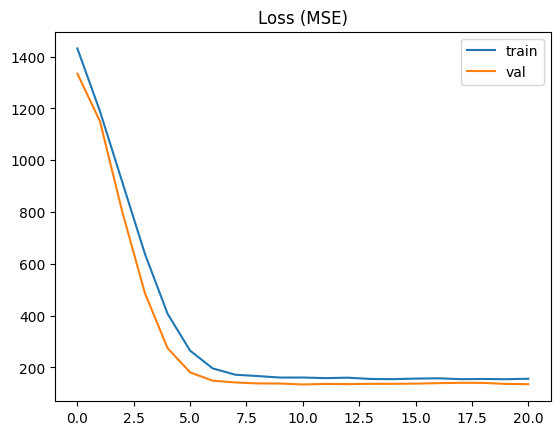

In [93]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.legend()

In [94]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error'])

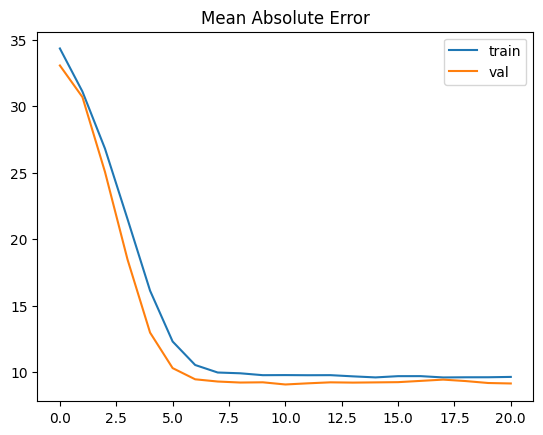

In [95]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='val')
plt.title('Mean Absolute Error')
plt.legend()

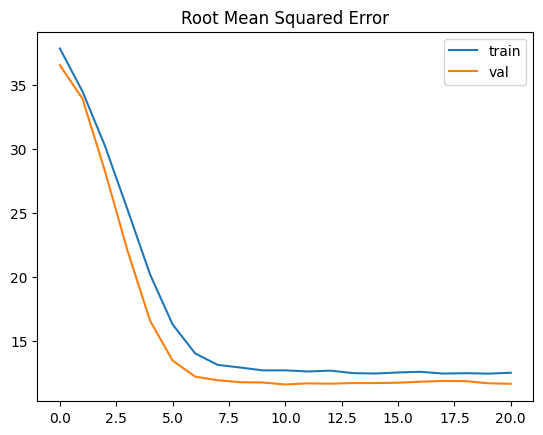

In [96]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='val')
plt.title('Root Mean Squared Error')
plt.legend()

In [97]:
eval_mse, eval_mae, eval_rmse = model.evaluate(eval_ds)
logger.info("Evaluation MSE: %s, MAE: %s, RMSE: %s", eval_mse, eval_mae, eval_rmse)

17/17 [==============================] - 0s 3ms/step - loss: 149.2151 - mean_absolute_error: 9.4301 - root_mean_squared_error: 12.2154


[2023-03-11 10:04:05,997][    INFO][__main__] Evaluation MSE: 149.215087890625, MAE: 9.430116653442383, RMSE: 12.215362548828125


In [98]:
wrapper_model = tf.keras.Model(inputs={
    ID_COLUMN: id_input,
    **feature_inputs,
}, outputs={
    ID_COLUMN: id_input,
    TARGET_COLUMN: tf.squeeze(model(feature_inputs, training=False), axis=1),
})

In [99]:
test_ds = df_to_dataset(test_transformed_df).batch(batch_size)

In [100]:
predictions = wrapper_model.predict(test_ds)

113/113 [==============================] - 0s 2ms/step


In [101]:
{k: v.shape for k, v in predictions.items()}

{'id': (3605,), 'Strength': (3605,)}

In [102]:
pl.DataFrame(predictions).write_csv(Path.cwd() / 'submission.csv')